## Jon Stingel
#### this notebook is for importing metabolic data and train/testing simple regression models on

In [1]:
import os
import pandas as pd
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
# import h5py
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns

# pd.set_option('display.max_rows',None,'display.max_columns',None)

In [2]:
## import the experimental values
# set paths
repobasedir = os.getcwd()
experimentalfile = os.path.join(repobasedir, 'experimentalMetabolics_all.csv')
# read in the file to dataframe
expmetcost_df = pd.read_csv(experimentalfile)
print(expmetcost_df)

     metabolics_all_avg subjectname     condname experimentname trialname
0              5.067015     wals024    walsslack          walsh   trial01
1              4.214548     wals077    walsslack          walsh   trial01
2              4.290595     wals088    walsslack          walsh   trial01
3              5.698502     wals112    walsslack          walsh   trial01
4              4.382331     wals127    walsslack          walsh   trial01
..                  ...         ...          ...            ...       ...
662           10.361830     sild035  sild10wrun0         silder   trial01
663            2.904840     sild035     sild20w0         silder   trial01
664           11.630630     sild035  sild20wrun0         silder   trial01
665            3.954340     sild035     sild30w0         silder   trial01
666           12.044730     sild035  sild30wrun0         silder   trial01

[667 rows x 5 columns]


In [3]:
## import all of the simulation results
# set all the paths
simresultspath = os.path.join(repobasedir,'..\\metabolicsResults\\')
muscleInversepath = os.path.join(simresultspath,'muscleInverse_100con\\')
# muscleInversepath = os.path.join(simresultspath,'muscleInverse_100con\\')
# muscleInverseWithEMGpath = os.path.join(simresultspath,'muscleInverseWithEMG\\')

## first handle the values in the regular muscle driven inverse problem
# get all the filenames
musclefiles = glob.glob(os.path.join(muscleInversepath,'*.csv'))
# load them all into a single dataframe
df_from_each_file = (pd.read_csv(f) for f in musclefiles)
# print(df_from_each_file)
muscle_df = pd.concat(df_from_each_file, ignore_index=True)
muscle_df

# need to get rid of the subject 14 noload trial 4
# muscle_df.drop([40], inplace=True)
# muscle_df.reset_index(drop=True, inplace=True)
# muscle_df



,Row,metabolics_all_avg,metabolics_act_avg,metabolics_short_avg,metabolics_basal_avg,metabolics_mech_avg,metabolics_gas_avg,metabolics_sol_avg,metabolics_bifemlh_avg,metabolics_recfem_avg,metabolics_swing_avg,metabolics_stance_avg,model_mass,subjectname,condname,experimentname,trialname
0,trial,13.449687,6.405999,7.431584,1.2,-1.587896,96.861613,104.292272,60.020656,107.377371,4.780602,8.380498,73.48,welk005,welknatural,welk,trial01
1,trial,11.451436,5.463892,6.027500,1.2,-1.239955,21.019578,14.060604,9.944778,25.856639,3.757848,7.632175,73.48,welk005,welknatural,welk,trial02
2,trial,11.657673,5.544188,5.975117,1.2,-1.061631,2.614486,7.620925,5.052060,1.004591,3.874889,7.257075,73.48,welk005,welknatural,welk,trial03
3,trial,12.091970,5.727921,6.798323,1.2,-1.634273,0.293716,1.771656,0.997746,14.523596,4.097572,7.432406,73.48,welk005,welknatural,welk,trial04
4,trial,9.614690,4.633782,4.351065,1.2,-0.570156,13.182863,119.223601,20.278635,11.297131,3.179334,5.831519,73.48,welk005,welkexo,welk,trial01
5,trial,9.278730,4.567247,4.198697,1.2,-0.687214,11.631266,106.182588,16.048408,9.814136,2.923021,5.863536,73.48,welk005,welkexo,welk,trial02
6,trial,10.879347,5.307555,5.501670,1.2,-1.129877,14.063307,124.940506,20.795212,10.839471,3.765553,6.550783,73.48,welk005,welkexo,welk,trial03
7,trial,10.238690,4.942795,4.697775,1.2,-0.601880,2.538701,5.308632,2.725772,1.470832,3.291729,6.124297,73.48,welk005,welkexo,welk,trial04
8,trial,11.741969,5.515926,5.897261,1.2,-0.871217,0.000000,0.000000,0.000000,0.000000,3.408313,7.829603,68.49,welk008,welknatural,welk,trial01
9,trial,11.501628,5.677835,5.793947,1.2,-1.170155,2.913282,6.215045,0.156827,1.564304,3.334961,7.683051,68.49,welk008,welknatural,welk,trial02


In [4]:
# manipulate and get a dataframe with all the values you are testing
test_df = muscle_df.groupby(['subjectname','condname','trialname']).agg({'metabolics_all_avg':['mean']})
test_df.columns = ['metabolics_all_avg_mean']
test_df = test_df.reset_index()
# print(test_df)

exp_df = expmetcost_df.groupby(['subjectname','condname','trialname']).agg({'metabolics_all_avg':['mean']})
exp_df.columns = ['metabolics_all_avg_mean']
exp_df = exp_df.reset_index()
# print(exp_df)


both_df = pd.merge(test_df, exp_df, how='right', on=['subjectname','condname','trialname'])
pd.set_option('display.max_rows',None) #,'display.max_columns',None)

bothtrim_df = both_df.dropna()
bothtrim_df

,subjectname,condname,trialname,metabolics_all_avg_mean_x,metabolics_all_avg_mean_y
513,welk002,welkexo,trial01,12.226963,8.972911
514,welk002,welkexo,trial02,11.406632,8.972911
515,welk002,welkexo,trial03,12.365193,8.972911
516,welk002,welkexo,trial04,11.141297,8.972911
529,welk002,welknatural,trial01,12.119943,9.390569
530,welk002,welknatural,trial02,13.872626,9.390569
531,welk002,welknatural,trial03,13.263834,9.390569
532,welk002,welknatural,trial04,13.093240,9.390569
545,welk003,welkexo,trial01,11.516401,9.520653
546,welk003,welkexo,trial02,11.244427,9.520653


In [39]:
# experimental = bothtrim_df['metabolics_all_avg_mean_y']
colors = ['blue','green','sandybrown','red','darkviolet','gold','magenta']

noload_df = bothtrim_df[bothtrim_df['condname'] == 'dembnoloadfree']
loaded_df = bothtrim_df[bothtrim_df['condname'] == 'dembloadedfree']

noload_exp = noload_df['metabolics_all_avg_mean_y'].values
noload_sim = noload_df['metabolics_all_avg_mean_x'].values
loaded_exp = loaded_df['metabolics_all_avg_mean_y'].values
loaded_sim = loaded_df['metabolics_all_avg_mean_x'].values

noload_speeds = [1.39, 1.48, 1.12, 1.48, 1.25, 1.56, 1.48]
loaded_speeds = [1.3, 1.16, 1.03, 1.34, 1.16, 1.21, 1.25]

# get means
noload_sub = noload_df.groupby('subjectname').mean()
noload_sub_std = noload_df.groupby('subjectname').std()

print(noload_sub)
print()




noload_sub_exp = noload_sub['metabolics_all_avg_mean_y'].values
noload_sub_exp = noload_sub_exp / noload_speeds
noload_sub_exp_std = noload_sub_std['metabolics_all_avg_mean_y'].values
noload_sub_exp_std = noload_sub_exp_std / noload_speeds

noload_sub_sim = noload_sub['metabolics_all_avg_mean_x'].values
noload_sub_sim = noload_sub_sim / noload_speeds
noload_sub_sim_std = noload_sub_std['metabolics_all_avg_mean_x'].values
noload_sub_sim_std = noload_sub_sim_std / noload_speeds

loaded_sub = loaded_df.groupby('subjectname').mean()
loaded_sub_std = loaded_df.groupby('subjectname').std()

loaded_sub_exp = loaded_sub['metabolics_all_avg_mean_y'].values
loaded_sub_exp = loaded_sub_exp / loaded_speeds
loaded_sub_exp_std = loaded_sub_std['metabolics_all_avg_mean_y'].values
loaded_sub_exp_std = loaded_sub_exp_std / loaded_speeds

loaded_sub_sim = loaded_sub['metabolics_all_avg_mean_x'].values
loaded_sub_sim = loaded_sub_sim / loaded_speeds
loaded_sub_sim_std = loaded_sub_std['metabolics_all_avg_mean_x'].values
loaded_sub_sim_std = loaded_sub_sim_std / loaded_speeds


# plot 
fig = plt.figure(figsize=(5.2,6.127))
ax = fig.add_subplot(111)
plt.scatter(noload_sim, noload_exp, marker='s')
plt.scatter(loaded_sim, loaded_exp, marker='^')

# generate unity line
unitx = np.linspace(0,8,50)
unity = unitx
plt.plot(unitx,unity, color='grey')

ax.set_aspect('equal')
plt.xlim((3,10))
plt.ylim((3,10))


# plot means 
fig2 = plt.figure(figsize=(5.2,6.127))
ax2 = fig2.add_subplot(111)
for i in range(len(noload_sub_sim)):
#     ax2.errorbar(noload_sub_sim[i], noload_sub_exp[i], xerr=noload_sub_sim_std[i], marker='s', color=colors[i])
#     ax2.errorbar(loaded_sub_sim[i], loaded_sub_exp[i], xerr=loaded_sub_sim_std[i], marker='^', color=colors[i])
    ax2.scatter(noload_sub_sim[i], noload_sub_exp[i], marker='s', color=colors[i])
    ax2.scatter(loaded_sub_sim[i], loaded_sub_exp[i], marker='^', color=colors[i])


# generate unity line
# unitx = np.linspace(3,10,50)
# unity = unitx
plt.plot(unitx,unity, color='grey')

fontsize=16

ax2.set_aspect('equal')
plt.xlim((2,7.5))
plt.ylim((2,7.5))
plt.legend()
ax2.set_xlabel('Simulation', fontsize=fontsize)
ax2.set_ylabel('Indirect Calorimetry', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax2.set_title('Gross Average Whole-Body Metabolic Cost\nNormalized by subject mass and speed\n(W/kg/(m/s))', 
             fontsize=fontsize)
plt.savefig('demb_wholebodymetresults.png', dpi=600)


test1 = np.concatenate((noload_sub_exp, loaded_sub_exp))
test2 = np.concatenate((noload_sub_sim, loaded_sub_sim))
mse_sub = mean_squared_error(test1,test2)
rmse_sub = np.sqrt(mse_sub)
print('rmse: %f' % rmse_sub)
# print(test1)
# print(test2)

rel_err = np.abs(test2-test1) / test1 *100
print('mean: %f' % np.mean(rel_err))

Empty DataFrame
Columns: [metabolics_all_avg_mean_x, metabolics_all_avg_mean_y]
Index: []



ValueError: operands could not be broadcast together with shapes (0,) (7,) 

# linear regression

In [8]:
############################################################################
# linear regression model
X = bothtrim_df['metabolics_all_avg_mean_x'].values.reshape(-1,1)
# print('x')
# print(X)
Y = bothtrim_df['metabolics_all_avg_mean_y'].values.reshape(-1,1)
# print('y')
# print(Y)

reg = LinearRegression()
reg.fit(X,Y)

print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
predictions = reg.predict(X)

# baseline error
mse_baseline = mean_squared_error(Y,X)
rmse_baseline = np.sqrt(mse_baseline)
print('\nRMSE baseline: %f W/kg' % rmse_baseline)

mse_lin = mean_squared_error(Y, predictions)
rmse_lin = np.sqrt(mse_lin)
print('\nRMSE linear regression %f W/kg' % rmse_lin)

The linear model is: Y = 6.5458 + 0.30399X

RMSE baseline: 2.106580 W/kg

RMSE linear regression 0.768939 W/kg


c:\users\jp\.conda\envs\pymoco\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\users\jp\.conda\envs\pymoco\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


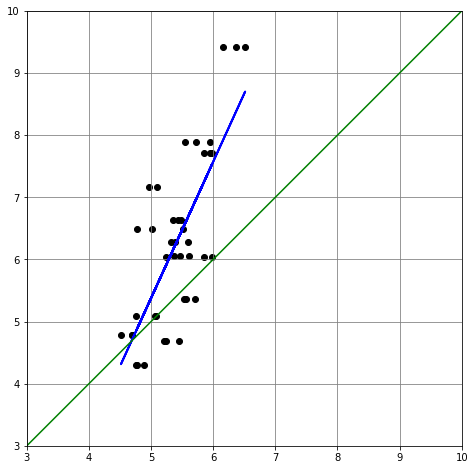

In [7]:
# plotting the linear regression model
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(bothtrim_df['metabolics_all_avg_mean_x'],
    bothtrim_df['metabolics_all_avg_mean_y'],
    c='black')
plt.plot(bothtrim_df['metabolics_all_avg_mean_x'],
    predictions,
    c='blue',
    linewidth=2)
plt.grid(color='grey')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-')

ax.set_aspect('equal')
plt.xlim((3,10))
plt.ylim((3,10))
plt.show()

In [8]:
#######################################################
## single decision tree implementation
X_dt = bothtrim_df.metabolics_all_avg_mean_x.values.reshape(-1,1)
Y_dt = bothtrim_df.metabolics_all_avg_mean_y.values.reshape(-1,1)

# x_train_dt, x_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt,Y_dt,test_size=0.15,random_state=12)
x_train_dt = X_dt[0:30,:]
temp = X_dt[36:-1,:]
x_train_dt = np.append(x_train_dt, temp, axis=0)
y_train_dt = Y_dt[0:30,:]
temp2 = Y_dt[36:-1,:]
y_train_dt = np.append(y_train_dt, temp2, axis=0)
x_test_dt = X_dt[30:36,:]
y_test_dt = Y_dt[30:36,:]

print(x_train_dt.shape)
print(y_train_dt.shape)
print(x_test_dt.shape)
print(y_test_dt.shape)

# x_train = x_train.reshape(-1,)
y_train_dt = y_train_dt.reshape(-1,)
# x_test_dt = x_test_dt.reshape(-1,)
y_test_dt = y_test_dt.reshape(-1,)
# print(x_train_dt.shape)
# print(y_train_dt.shape)

DecisionTreeRegModel = DecisionTreeRegressor(random_state=13, criterion='mse')
DecisionTreeRegModel.fit(x_train_dt, y_train_dt)



(34, 1)
(34, 1)
(6, 1)
(6, 1)


DecisionTreeRegressor(random_state=13)

y_test_dt:
[7.708152 7.708152 7.708152 6.061044 6.061044 6.061044]
y_pred_dt:
[6.040289 7.890412 6.040289 4.682754 6.282373 6.282373]

RMSE: 1.125049


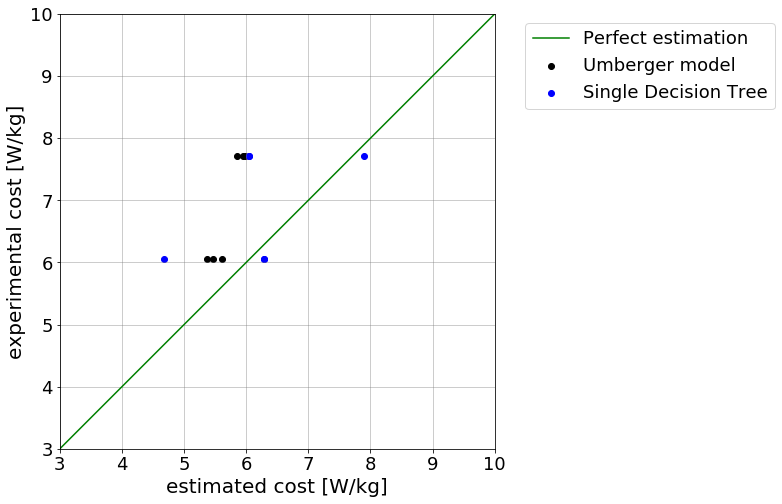

In [9]:
# try some predictions
print('y_test_dt:')
print(y_test_dt)
y_pred_dt = DecisionTreeRegModel.predict(x_test_dt)
print('y_pred_dt:')
print(y_pred_dt)

# error
mse_dt = mean_squared_error(y_test_dt, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
print('\nRMSE: %f' % rmse_dt)

# plot the random forest 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(x_test_dt,y_test_dt,
    c='black', label='Umberger model')
plt.scatter(y_pred_dt, y_test_dt,
    c='blue', label='Single Decision Tree')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

In [10]:
########################################################
## random forest implementation

X_rf = bothtrim_df.metabolics_all_avg_mean_x.values.reshape(-1,1)
Y_rf = bothtrim_df.metabolics_all_avg_mean_y.values.reshape(-1,1)

# x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf,Y_rf,test_size=0.15,random_state=12)
x_train_rf = X_rf[0:30,:]
temp = X_rf[36:-1,:]
x_train_rf = np.append(x_train_rf, temp, axis=0)
y_train_rf = Y_rf[0:30,:]
temp2 = Y_rf[36:-1,:]
y_train_rf = np.append(y_train_rf, temp2, axis=0)
x_test_rf = X_rf[30:36,:]
y_test_rf = Y_rf[30:36,:]




# x_train_rf = x_train_rf.reshape(-1,)
y_train_rf = y_train_rf.reshape(-1,)
# x_test_rf = x_test_rf.reshape(-1,)
y_test_rf = y_test_rf.reshape(-1,)
# print(x_train_rf.shape)
# print(y_train_rf.shape)

RandomForestRegModel = RandomForestRegressor(random_state=13, n_estimators=50)
RandomForestRegModel.fit(x_train_rf, y_train_rf)



RandomForestRegressor(n_estimators=50, random_state=13)

y_test_rf:
[7.708152 7.708152 7.708152 6.061044 6.061044 6.061044]
y_pred_rf:
[6.69272796 7.43277716 6.6557255  5.37520434 6.38251916 6.37262628]

RMSE: 0.693460


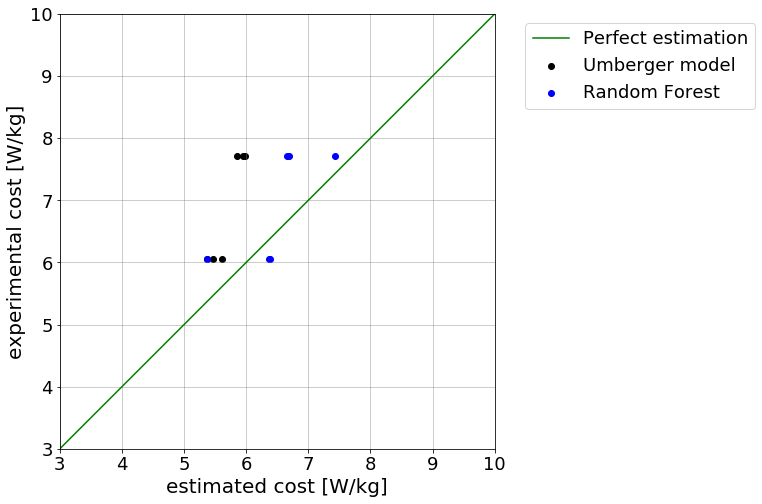

In [11]:
# try some predictions
print('y_test_rf:')
print(y_test_rf)
y_pred_rf = RandomForestRegModel.predict(x_test_rf)
print('y_pred_rf:')
print(y_pred_rf)

# error
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print('\nRMSE: %f' % rmse_rf)

# plot the random forest 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(x_test_rf,y_test_rf,
    c='black', label='Umberger model')
plt.scatter(y_pred_rf, y_test_rf,
    c='blue', label='Random Forest')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

# Getting X  values with all the umberger components

In [12]:
## import all of the simulation results
# set all the paths
simresultspath = os.path.join(repobasedir,'..\\metabolicsResults\\')
muscleInversepath = os.path.join(simresultspath,'muscleInverse\\')
muscleInverseWithEMGpath = os.path.join(simresultspath,'muscleInverseWithEMG\\')

## first handle the values in the regular muscle driven inverse problem
# get all the filenames
musclefiles = glob.glob(os.path.join(muscleInversepath,'*.csv'))
# load them all into a single dataframe
df_from_each_file = (pd.read_csv(f) for f in musclefiles)
# print(df_from_each_file)
muscle_df = pd.concat(df_from_each_file, ignore_index=True)
muscle_df.sort_values(by=['subjectname','condname','trialname'],inplace=True)
muscle_df.drop(['Row'],inplace=True,axis=1)
muscle_df.drop([40], inplace=True)
muscle_df.reset_index(inplace=True,drop=True)

print(muscle_df)

    metabolics_all_avg  metabolics_act_avg  metabolics_short_avg  \
0             5.854988            2.163104              1.745012   
1             5.243187            1.812768              1.560882   
2             5.982183            2.098366              2.220253   
3             5.205230            1.772767              1.353764   
4             5.453218            1.873235              1.571584   
5             5.232866            1.833161              1.418528   
6             5.377935            2.038594              1.565956   
7             5.319551            1.935891              1.671981   
8             5.592660            2.111974              1.587234   
9             4.764115            1.582758              1.408510   
10            5.081854            1.670328              1.270100   
11            5.056257            1.638048              1.319619   
12            5.357572            2.099804              1.351984   
13            5.438953            2.150757      

In [13]:
# figure out how to pair down the experimental to only have these ones
combos = []
for index, row in muscle_df.iterrows():
    subj = row['subjectname']
    cond = row['condname']
    trial = row['trialname']
    combos.append((subj,cond,trial))
combosunique = set(combos)
# print(combosunique)

idk = pd.merge(expmetcost_df, muscle_df, how='left', indicator=True)
idk2 = idk.reset_index()

indextodrop = []
for index, row in idk2.iterrows():
    subj = row['subjectname']
    cond = row['condname']
    trial = row['trialname']
    if (subj,cond,trial) not in combosunique:
        indextodrop.append(index)

idk3 = idk2.drop(indextodrop)
# print(idk3)
idk4 = idk3.drop(['index','_merge','metabolics_mech_avg','metabolics_basal_avg','metabolics_short_avg','metabolics_act_avg'], axis=1)
# print(idk4)
# sort the dataframe TODO sort the sims one the same way
idk5 = idk4.sort_values(by=['subjectname','condname','trialname'])
idk5.reset_index(inplace=True,drop=True)

exp_df = idk5
# print(exp_df)


# linear regression on multiple values

In [14]:
# exp_df
# muscle_df

############################################################################
# linear regression model
X_multi_lg = muscle_df.iloc[:,0:5].values
# print('x')
print(X_multi_lg.shape)
Y_multi_lg = exp_df.iloc[:,0].values
# print('y')
print(Y_multi_lg.shape)

# split into sets
# x_train_multi_lg,x_test_multi_lg,y_train_multi_lg,y_test_multi_lg = train_test_split(X_multi_lg,Y_multi_lg,
#                                                                                      test_size=0.15,
#                                                                                     random_state=12)
x_train_multi_lg = X_multi_lg[0:30,:]
temp = X_multi_lg[36:-1,:]
x_train_multi_lg = np.append(x_train_multi_lg, temp, axis=0)
y_train_multi_lg = Y_multi_lg[0:30]
temp2 = Y_multi_lg[36:-1]
y_train_multi_lg = np.append(y_train_multi_lg, temp2, axis=0)
x_test_multi_lg = X_multi_lg[30:36,:]
y_test_multi_lg = Y_multi_lg[30:36]

# set up the regression
reg_multi_lg = LinearRegression()
reg_multi_lg.fit(x_train_multi_lg,y_train_multi_lg)

# print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
y_pred_multi_lg_test = reg_multi_lg.predict(x_test_multi_lg)
y_pred_multi_lg_train = reg_multi_lg.predict(x_train_multi_lg)

# baseline error
mse_baseline = mean_squared_error(Y_multi_lg,X_multi_lg[:,0])
rmse_baseline = np.sqrt(mse_baseline)
print('\nRMSE baseline: %f W/kg' % rmse_baseline)

mse_multi_lg_train = mean_squared_error(y_train_multi_lg, y_pred_multi_lg_train)
rmse_multi_lg_train = np.sqrt(mse_multi_lg_train)
print('\nRMSE training linear regression %f W/kg' % rmse_multi_lg_train)

mse_multi_lg_test = mean_squared_error(y_test_multi_lg, y_pred_multi_lg_test)
rmse_multi_lg_test = np.sqrt(mse_multi_lg_test)
print('\nRMSE test linear regression %f W/kg' % rmse_multi_lg_test)

(41, 5)
(41,)

RMSE baseline: 1.376561 W/kg

RMSE training linear regression 0.830224 W/kg

RMSE test linear regression 0.503560 W/kg


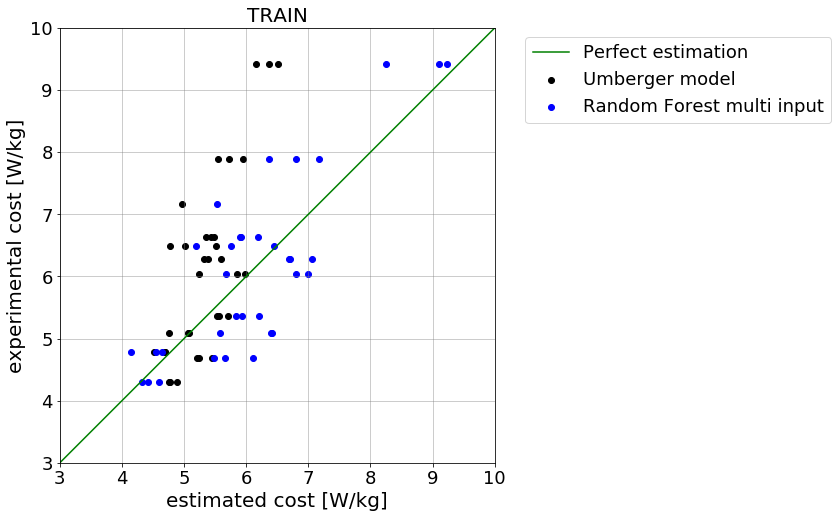

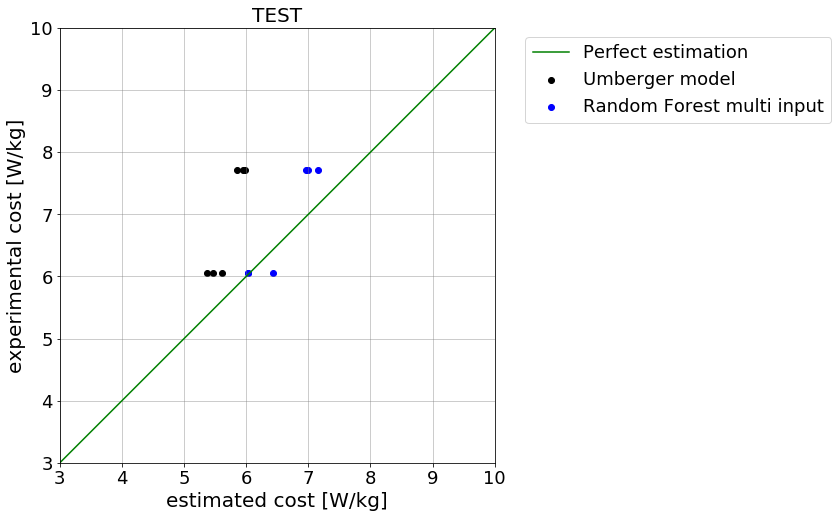

In [15]:
# plot the random forest
fig1 = plt.figure(figsize=(8,8))
ax = fig1.add_subplot(111)

plt.scatter(x_train_multi_lg[:,0],y_train_multi_lg,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_lg_train, y_train_multi_lg,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TRAIN',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111)

plt.scatter(x_test_multi_lg[:,0],y_test_multi_lg,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_lg_test, y_test_multi_lg,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TEST',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

## random forest for all umberger inputs

In [16]:
# set up the X and Y
X_multi_rf = muscle_df.iloc[:,0:5].values
# print(X_multi_rf)
Y_multi_rf = exp_df.iloc[:,0].values
# print(Y_multi_rf)

# split into sets
# x_train_multi_rf,x_test_multi_rf,y_train_multi_rf,y_test_multi_rf = train_test_split(X_multi_rf,Y_multi_rf,
#                                                                                      test_size=0.15,
#                                                                                     random_state=12)
x_train_multi_rf = X_multi_rf[0:30,:]
temp = X_multi_rf[36:-1,:]
x_train_multi_rf = np.append(x_train_multi_rf, temp, axis=0)
y_train_multi_rf = Y_multi_rf[0:30]
temp2 = Y_multi_rf[36:-1]
y_train_multi_rf = np.append(y_train_multi_rf, temp2, axis=0)
x_test_multi_rf = X_multi_rf[30:36,:]
y_test_multi_rf = Y_multi_rf[30:36]




# print(X_multi_rf.shape)
# print(Y_multi_rf.shape)

print(x_train_multi_rf.shape)
print(y_train_multi_rf.shape)
print(x_test_multi_rf.shape)
print(y_test_multi_rf.shape)

multiregrf = RandomForestRegressor(n_estimators=100, random_state=13)
multiregrf.fit(x_train_multi_rf,y_train_multi_rf)
y_pred_multi_rf = multiregrf.predict(x_test_multi_rf)
y_pred_multi_rf_train = multiregrf.predict(x_train_multi_rf)


(34, 5)
(34,)
(6, 5)
(6,)


y_test_multi_rf:
[7.708152 7.708152 7.708152 6.061044 6.061044 6.061044]
y_pred_rf:
[7.18435102 7.60293609 6.20313636 6.36337094 6.99860502 5.93257001]

RMSE baseline: 1.376561

RMSE training: 0.399358

RMSE test: 0.767837


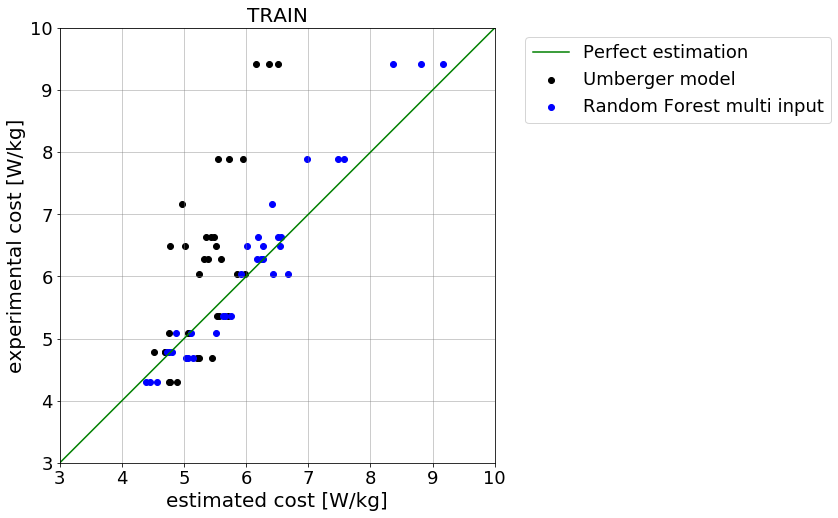

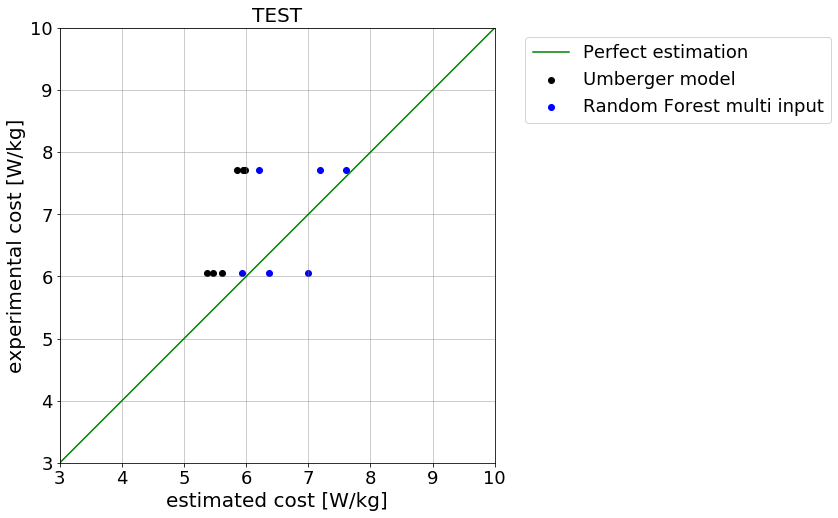

In [17]:
# try some predictions
print('y_test_multi_rf:')
print(y_test_multi_rf)
print('y_pred_rf:')
print(y_pred_multi_rf)

# error
mse_multi_rf_base = mean_squared_error(Y_multi_rf,X_multi_rf[:,0])
rmse_multi_rf_base = np.sqrt(mse_multi_rf_base)
print('\nRMSE baseline: %f' % rmse_multi_rf_base)

mse_multi_rf_train = mean_squared_error(y_train_multi_rf, y_pred_multi_rf_train)
rmse_multi_rf_train = np.sqrt(mse_multi_rf_train)
print('\nRMSE training: %f' % rmse_multi_rf_train)

mse_multi_rf = mean_squared_error(y_test_multi_rf, y_pred_multi_rf)
rmse_multi_rf = np.sqrt(mse_multi_rf)
print('\nRMSE test: %f' % rmse_multi_rf)

# plot the random forest
fig1 = plt.figure(figsize=(8,8))
ax = fig1.add_subplot(111)

plt.scatter(x_train_multi_rf[:,0],y_train_multi_rf,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_rf_train, y_train_multi_rf,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TRAIN',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111)

plt.scatter(x_test_multi_rf[:,0],y_test_multi_rf,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_rf, y_test_multi_rf,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TEST',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

In [18]:
# get importance of features
importance = list(multiregrf.feature_importances_)
print(importance)

featurelist = list(muscle_df.columns)
# featurelist.remove(['subjectname','condname','experimentname','trialname'])
featurelist.remove('subjectname')
featurelist.remove('condname')
featurelist.remove('experimentname')
featurelist.remove('trialname')

# list of tubles with variable and importance
feature_importances = [(feature, round(importance,2)) for feature, importance in zip(featurelist,importance)]

# sort the feature importances bu most important 
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

[0.4751609973979485, 0.23110797528369062, 0.08518203200666513, 0.0, 0.20854899531169566]
Variable: metabolics_all_avg   Importance: 0.48
Variable: metabolics_act_avg   Importance: 0.23
Variable: metabolics_mech_avg  Importance: 0.21
Variable: metabolics_short_avg Importance: 0.09
Variable: metabolics_basal_avg Importance: 0.0


[None, None, None, None, None]

## try a subject calibration for 2 subjects

In [19]:
# random forest model with one example from a subject (simulate a calibration)
# set up the X and Y
X_multi_rf_calib = muscle_df.iloc[:,0:5].values
# print(X_multi_rf)
Y_multi_rf_calib = exp_df.iloc[:,0].values
# print(Y_multi_rf)

# split into sets
# x_train_multi_rf,x_test_multi_rf,y_train_multi_rf,y_test_multi_rf = train_test_split(X_multi_rf,Y_multi_rf,
#                                                                                      test_size=0.15,
#                                                                                     random_state=12)
x_train_multi_rf_calib = X_multi_rf_calib[0:31,:]
temp = X_multi_rf_calib[35:-1,:]
x_train_multi_rf_calib = np.append(x_train_multi_rf_calib, temp, axis=0)
y_train_multi_rf_calib = Y_multi_rf_calib[0:31]
temp2 = Y_multi_rf_calib[35:-1]
y_train_multi_rf_calib = np.append(y_train_multi_rf_calib, temp2, axis=0)
x_test_multi_rf_calib = X_multi_rf_calib[31:35,:]
y_test_multi_rf_calib = Y_multi_rf_calib[31:35]

# print(X_multi_rf_calib.shape)
# print(Y_multi_rf_calib.shape)

print(x_train_multi_rf_calib.shape)
print(y_train_multi_rf_calib.shape)
print(x_test_multi_rf_calib.shape)
print(y_test_multi_rf_calib.shape)

multiregrf_calib = RandomForestRegressor(n_estimators=1000, random_state=13)
multiregrf_calib.fit(x_train_multi_rf_calib,y_train_multi_rf_calib)
y_pred_multi_rf_calib = multiregrf_calib.predict(x_test_multi_rf_calib)
y_pred_multi_rf_calib_train = multiregrf_calib.predict(x_train_multi_rf_calib)


# try some predictions
print('y_test_multi_rf_calib:')
print(y_test_multi_rf_calib)
print('y_pred_rf_calib:')
print(y_pred_multi_rf_calib)

# error
mse_multi_rf_calib_base = mean_squared_error(Y_multi_rf_calib,X_multi_rf_calib[:,0])
rmse_multi_rf_calib_base = np.sqrt(mse_multi_rf_calib_base)
print('\nRMSE baseline: %f' % rmse_multi_rf_calib_base)

mse_multi_rf_calib_train = mean_squared_error(y_train_multi_rf_calib, y_pred_multi_rf_calib_train)
rmse_multi_rf_calib_train = np.sqrt(mse_multi_rf_calib_train)
print('\nRMSE training: %f' % rmse_multi_rf_calib_train)

mse_multi_rf_calib = mean_squared_error(y_test_multi_rf_calib, y_pred_multi_rf_calib)
rmse_multi_rf_calib = np.sqrt(mse_multi_rf_calib)
print('\nRMSE test: %f' % rmse_multi_rf_calib)

(36, 5)
(36,)
(4, 5)
(4,)
y_test_multi_rf_calib:
[7.708152 7.708152 6.061044 6.061044]
y_pred_rf_calib:
[7.66125296 6.28014376 6.49602861 7.08379578]

RMSE baseline: 1.376561

RMSE training: 0.369119

RMSE test: 0.905075


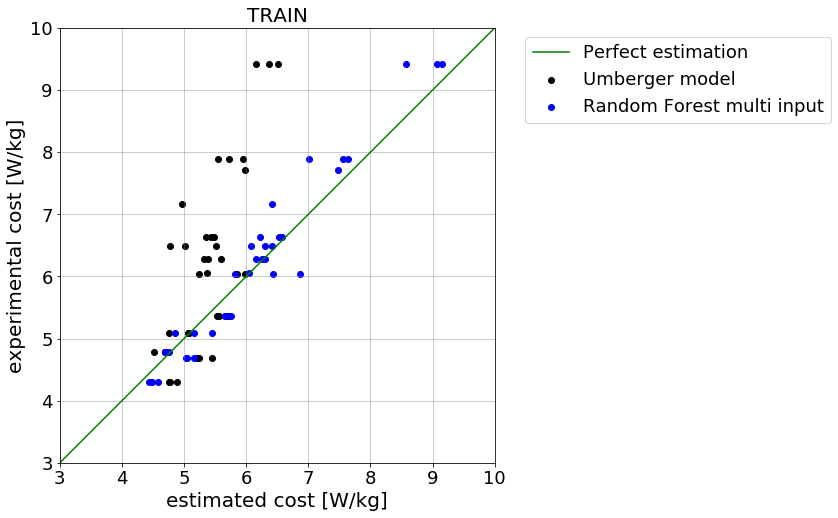

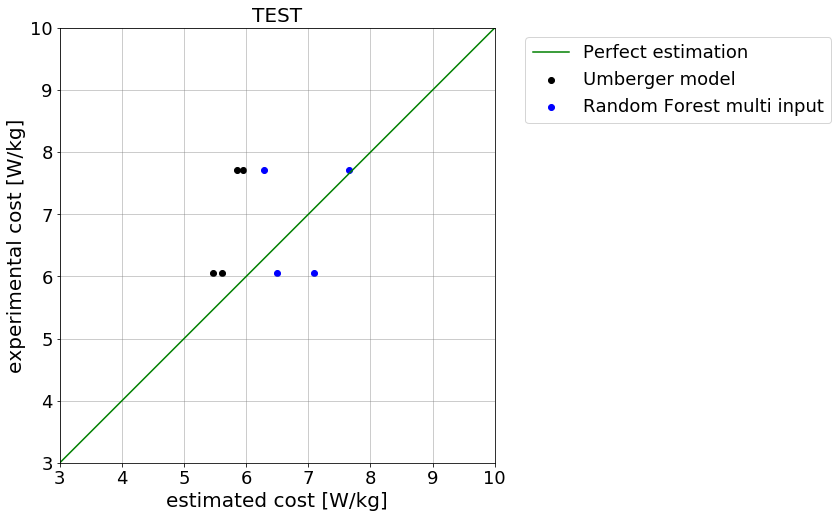

In [20]:

# plot the random forest
fig1 = plt.figure(figsize=(8,8))
ax = fig1.add_subplot(111)

plt.scatter(x_train_multi_rf_calib[:,0],y_train_multi_rf_calib,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_rf_calib_train, y_train_multi_rf_calib,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TRAIN',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111)

plt.scatter(x_test_multi_rf_calib[:,0],y_test_multi_rf_calib,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_rf_calib, y_test_multi_rf_calib,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TEST',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

## try deep learning model

In [21]:
# set up the X and Y
X_multi_nn = muscle_df.iloc[:,0:5].values
# print(X_multi_nn)
Y_multi_nn = exp_df.iloc[:,0].values.reshape(-1,1)
# print(Y_multi_nn.shape)

# split into sets
# x_train_multi_nn,x_test_multi_nn,y_train_multi_nn,y_test_multi_nn = train_test_split(X_multi_nn,Y_multi_nn,
#                                                                                      test_size=0.15,
#                                                                                     random_state=12)
x_train_multi_nn = X_multi_nn[0:30,:]
temp = X_multi_nn[36:-1,:]
x_train_multi_nn = np.append(x_train_multi_nn, temp, axis=0)
y_train_multi_nn = Y_multi_nn[0:30]
temp2 = Y_multi_nn[36:-1]
y_train_multi_nn = np.append(y_train_multi_nn, temp2, axis=0)
x_test_multi_nn = X_multi_nn[30:36,:]
y_test_multi_nn = Y_multi_nn[30:36]

# reshape
x_train_multi_nn.reshape



# print(X_multi_nn.shape)
# print(Y_multi_nn.shape)

print(x_train_multi_nn.shape)
print(y_train_multi_nn.shape)
print(x_test_multi_nn.shape)
print(y_test_multi_nn.shape)


(34, 5)
(34, 1)
(6, 5)
(6, 1)


In [22]:
# model create and train
import numpy as np
from keras import layers
from keras.layers import Input, Dense #, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
# from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



# from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
# from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# from kt_utils import *

import keras.backend as K
# K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

Using TensorFlow backend.


In [23]:
# create the base model
def baseline_model(input_shape):
    
#     # create the model
#     model = Sequential()
#     model.add(Dense(5, input_dim=5, kernel_initializer='normal', activation='relu'))
#     model.add(Dense(4, kernel_initializer='normal'))
#     model.add(Dense(2, kernel_initializer='normal'))
#     model.add(Dense(1, kernel_initializer='normal'))
#     # compile model
#     model.compile(loss='mean_squared_error', optimizer='adam')
    
    X_input = Input(input_shape)
    
    X = Dense(15, input_dim=input_shape, kernel_initializer='normal', activation='relu')(X_input)
    X = Dense(30, activation='relu', kernel_initializer='normal')(X)
    X = Dense(15, activation='relu', kernel_initializer='normal')(X)
    X = Dense(3, activation='relu', kernel_initializer='normal')(X)
    X = Dense(1, kernel_initializer='normal', activation='linear')(X)
    
    model = Model(inputs=X_input, outputs=X, name='baselineModel')
    
    
    return model

In [24]:
# evaluate model
# estimator = KerasRegressor(build_fn=baseline_model, epochs=1000, verbose=0)
# kfold = KFold(n_splits=7)
# results = cross_val_score(estimator, x_train_multi_nn, y_train_multi_nn, cv=kfold)
# results = cross_val_score(estimator, X_multi_nn, Y_multi_nn, cv=kfold)

# print('Baseline: %.2f (%.2f) MSE' % (results.mean(), results.std()))
x_train_multi_nn.shape[1:]

(5,)

In [25]:
# create the model
basemodel = baseline_model(x_train_multi_nn.shape[1:])

In [26]:
basemodel.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mean_squared_error'])

In [27]:
basemodel.fit(x=x_train_multi_nn, y=y_train_multi_nn, epochs=1000)


Epoch 1/1000
34/34 [==============================] - 0s 14ms/step - loss: 39.5380 - mean_squared_error: 39.5380
Epoch 2/1000
34/34 [==============================] - 0s 176us/step - loss: 39.5134 - mean_squared_error: 39.5134
Epoch 3/1000
34/34 [==============================] - 0s 146us/step - loss: 39.4895 - mean_squared_error: 39.4895
Epoch 4/1000
34/34 [==============================] - 0s 176us/step - loss: 39.4646 - mean_squared_error: 39.4646
Epoch 5/1000
34/34 [==============================] - 0s 147us/step - loss: 39.4402 - mean_squared_error: 39.4402
Epoch 6/1000
34/34 [==============================] - 0s 234us/step - loss: 39.4151 - mean_squared_error: 39.4151
Epoch 7/1000
34/34 [==============================] - 0s 176us/step - loss: 39.3901 - mean_squared_error: 39.3901
Epoch 8/1000
34/34 [==============================] - 0s 176us/step - loss: 39.3648 - mean_squared_error: 39.3648
Epoch 9/1000
34/34 [==============================] - 0s 176us/step - loss: 39.3391 - me

34/34 [==============================] - 0s 147us/step - loss: 7.3409 - mean_squared_error: 7.3409
Epoch 71/1000
34/34 [==============================] - 0s 147us/step - loss: 5.9991 - mean_squared_error: 5.9991
Epoch 72/1000
34/34 [==============================] - 0s 147us/step - loss: 4.7980 - mean_squared_error: 4.7980
Epoch 73/1000
34/34 [==============================] - 0s 117us/step - loss: 3.7437 - mean_squared_error: 3.7437
Epoch 74/1000
34/34 [==============================] - 0s 118us/step - loss: 2.8511 - mean_squared_error: 2.8511
Epoch 75/1000
34/34 [==============================] - 0s 147us/step - loss: 2.1873 - mean_squared_error: 2.1873
Epoch 76/1000
34/34 [==============================] - 0s 147us/step - loss: 1.7121 - mean_squared_error: 1.7121
Epoch 77/1000
34/34 [==============================] - 0s 117us/step - loss: 1.4324 - mean_squared_error: 1.4324
Epoch 78/1000
34/34 [==============================] - 0s 147us/step - loss: 1.3640 - mean_squared_error: 1.36

34/34 [==============================] - 0s 147us/step - loss: 1.3734 - mean_squared_error: 1.3734
Epoch 215/1000
34/34 [==============================] - 0s 147us/step - loss: 1.3450 - mean_squared_error: 1.3450
Epoch 216/1000
34/34 [==============================] - 0s 147us/step - loss: 1.3364 - mean_squared_error: 1.3364
Epoch 217/1000
34/34 [==============================] - 0s 117us/step - loss: 1.3290 - mean_squared_error: 1.3290
Epoch 218/1000
34/34 [==============================] - 0s 147us/step - loss: 1.3199 - mean_squared_error: 1.3199
Epoch 219/1000
34/34 [==============================] - 0s 147us/step - loss: 1.3157 - mean_squared_error: 1.3157
Epoch 220/1000
34/34 [==============================] - 0s 147us/step - loss: 1.3176 - mean_squared_error: 1.3176
Epoch 221/1000
34/34 [==============================] - 0s 147us/step - loss: 1.3371 - mean_squared_error: 1.3371
Epoch 222/1000
34/34 [==============================] - 0s 147us/step - loss: 1.3445 - mean_squared_err

34/34 [==============================] - 0s 117us/step - loss: 1.3148 - mean_squared_error: 1.3148
Epoch 287/1000
34/34 [==============================] - 0s 147us/step - loss: 1.3078 - mean_squared_error: 1.3078
Epoch 288/1000
34/34 [==============================] - 0s 117us/step - loss: 1.3048 - mean_squared_error: 1.3048
Epoch 289/1000
34/34 [==============================] - 0s 117us/step - loss: 1.2983 - mean_squared_error: 1.2983
Epoch 290/1000
34/34 [==============================] - 0s 117us/step - loss: 1.2974 - mean_squared_error: 1.2974
Epoch 291/1000
34/34 [==============================] - 0s 117us/step - loss: 1.2970 - mean_squared_error: 1.2970
Epoch 292/1000
34/34 [==============================] - 0s 117us/step - loss: 1.2959 - mean_squared_error: 1.2959
Epoch 293/1000
34/34 [==============================] - 0s 117us/step - loss: 1.2970 - mean_squared_error: 1.2970
Epoch 294/1000
34/34 [==============================] - 0s 147us/step - loss: 1.2951 - mean_squared_err

34/34 [==============================] - 0s 146us/step - loss: 1.2984 - mean_squared_error: 1.2984
Epoch 429/1000
34/34 [==============================] - 0s 147us/step - loss: 1.3040 - mean_squared_error: 1.3040
Epoch 430/1000
34/34 [==============================] - 0s 147us/step - loss: 1.3159 - mean_squared_error: 1.3159
Epoch 431/1000
34/34 [==============================] - 0s 117us/step - loss: 1.3178 - mean_squared_error: 1.3178
Epoch 432/1000
34/34 [==============================] - 0s 146us/step - loss: 1.3131 - mean_squared_error: 1.3131
Epoch 433/1000
34/34 [==============================] - 0s 147us/step - loss: 1.3103 - mean_squared_error: 1.3103
Epoch 434/1000
34/34 [==============================] - 0s 117us/step - loss: 1.2992 - mean_squared_error: 1.2992
Epoch 435/1000
34/34 [==============================] - 0s 147us/step - loss: 1.2822 - mean_squared_error: 1.2822
Epoch 436/1000
34/34 [==============================] - 0s 117us/step - loss: 1.2617 - mean_squared_err

34/34 [==============================] - 0s 176us/step - loss: 1.2577 - mean_squared_error: 1.2577
Epoch 501/1000
34/34 [==============================] - 0s 176us/step - loss: 1.2475 - mean_squared_error: 1.2475
Epoch 502/1000
34/34 [==============================] - 0s 147us/step - loss: 1.2464 - mean_squared_error: 1.2464
Epoch 503/1000
34/34 [==============================] - 0s 235us/step - loss: 1.2421 - mean_squared_error: 1.2421
Epoch 504/1000
34/34 [==============================] - 0s 176us/step - loss: 1.2414 - mean_squared_error: 1.2414
Epoch 505/1000
34/34 [==============================] - 0s 205us/step - loss: 1.2415 - mean_squared_error: 1.2415
Epoch 506/1000
34/34 [==============================] - 0s 176us/step - loss: 1.2396 - mean_squared_error: 1.2396
Epoch 507/1000
34/34 [==============================] - 0s 147us/step - loss: 1.2389 - mean_squared_error: 1.2389
Epoch 508/1000
34/34 [==============================] - 0s 264us/step - loss: 1.2404 - mean_squared_err

34/34 [==============================] - 0s 117us/step - loss: 1.2579 - mean_squared_error: 1.2579
Epoch 644/1000
34/34 [==============================] - 0s 147us/step - loss: 1.2536 - mean_squared_error: 1.2536
Epoch 645/1000
34/34 [==============================] - 0s 117us/step - loss: 1.2417 - mean_squared_error: 1.2417
Epoch 646/1000
34/34 [==============================] - 0s 147us/step - loss: 1.2335 - mean_squared_error: 1.2335
Epoch 647/1000
34/34 [==============================] - 0s 117us/step - loss: 1.2266 - mean_squared_error: 1.2266
Epoch 648/1000
34/34 [==============================] - 0s 147us/step - loss: 1.2220 - mean_squared_error: 1.2220
Epoch 649/1000
34/34 [==============================] - 0s 146us/step - loss: 1.2195 - mean_squared_error: 1.2195
Epoch 650/1000
34/34 [==============================] - 0s 117us/step - loss: 1.2149 - mean_squared_error: 1.2149
Epoch 651/1000
34/34 [==============================] - 0s 147us/step - loss: 1.2101 - mean_squared_err

34/34 [==============================] - 0s 147us/step - loss: 1.1894 - mean_squared_error: 1.1894
Epoch 716/1000
34/34 [==============================] - 0s 117us/step - loss: 1.1984 - mean_squared_error: 1.1984
Epoch 717/1000
34/34 [==============================] - 0s 147us/step - loss: 1.2197 - mean_squared_error: 1.2197
Epoch 718/1000
34/34 [==============================] - 0s 176us/step - loss: 1.2507 - mean_squared_error: 1.2507
Epoch 719/1000
34/34 [==============================] - 0s 117us/step - loss: 1.2719 - mean_squared_error: 1.2719
Epoch 720/1000
34/34 [==============================] - 0s 117us/step - loss: 1.2864 - mean_squared_error: 1.2864
Epoch 721/1000
34/34 [==============================] - 0s 147us/step - loss: 1.2954 - mean_squared_error: 1.2954
Epoch 722/1000
34/34 [==============================] - 0s 147us/step - loss: 1.2887 - mean_squared_error: 1.2887
Epoch 723/1000
34/34 [==============================] - 0s 88us/step - loss: 1.2638 - mean_squared_erro

34/34 [==============================] - 0s 117us/step - loss: 1.1794 - mean_squared_error: 1.1794
Epoch 788/1000
34/34 [==============================] - 0s 117us/step - loss: 1.1772 - mean_squared_error: 1.1772
Epoch 789/1000
34/34 [==============================] - 0s 117us/step - loss: 1.1758 - mean_squared_error: 1.1758
Epoch 790/1000
34/34 [==============================] - 0s 176us/step - loss: 1.1738 - mean_squared_error: 1.1738
Epoch 791/1000
34/34 [==============================] - 0s 117us/step - loss: 1.1770 - mean_squared_error: 1.1770
Epoch 792/1000
34/34 [==============================] - 0s 147us/step - loss: 1.1794 - mean_squared_error: 1.1794
Epoch 793/1000
34/34 [==============================] - 0s 117us/step - loss: 1.1820 - mean_squared_error: 1.1820
Epoch 794/1000
34/34 [==============================] - 0s 117us/step - loss: 1.1858 - mean_squared_error: 1.1858
Epoch 795/1000
34/34 [==============================] - 0s 147us/step - loss: 1.1948 - mean_squared_err

34/34 [==============================] - 0s 117us/step - loss: 1.1740 - mean_squared_error: 1.1740
Epoch 860/1000
34/34 [==============================] - 0s 176us/step - loss: 1.1646 - mean_squared_error: 1.1646
Epoch 861/1000
34/34 [==============================] - 0s 147us/step - loss: 1.1631 - mean_squared_error: 1.1631
Epoch 862/1000
34/34 [==============================] - 0s 147us/step - loss: 1.1558 - mean_squared_error: 1.1558
Epoch 863/1000
34/34 [==============================] - 0s 117us/step - loss: 1.1585 - mean_squared_error: 1.1585
Epoch 864/1000
34/34 [==============================] - 0s 117us/step - loss: 1.1559 - mean_squared_error: 1.1559
Epoch 865/1000
34/34 [==============================] - 0s 117us/step - loss: 1.1574 - mean_squared_error: 1.1574
Epoch 866/1000
34/34 [==============================] - 0s 147us/step - loss: 1.1554 - mean_squared_error: 1.1554
Epoch 867/1000
34/34 [==============================] - 0s 146us/step - loss: 1.1557 - mean_squared_err

In [28]:
preds = basemodel.evaluate(x=x_test_multi_nn, y=y_test_multi_nn)
print()
print('Loss = ' + str(preds[0]))
print('test MSE = ' + str(preds[1]))

6/6 [==============================] - 0s 11ms/step

Loss = 0.3614571988582611
test MSE = 0.3614571988582611


In [29]:
y_pred_train_multi_nn = basemodel.predict(x=x_train_multi_nn)
y_pred_test_multi_nn = basemodel.predict(x=x_test_multi_nn)

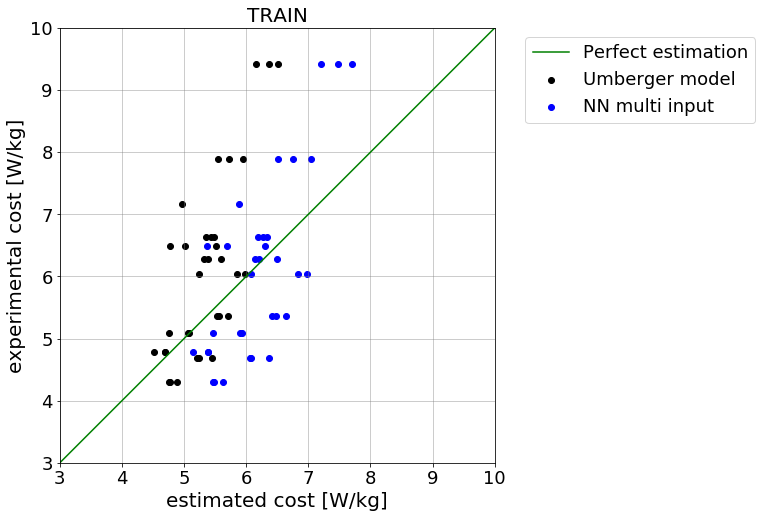

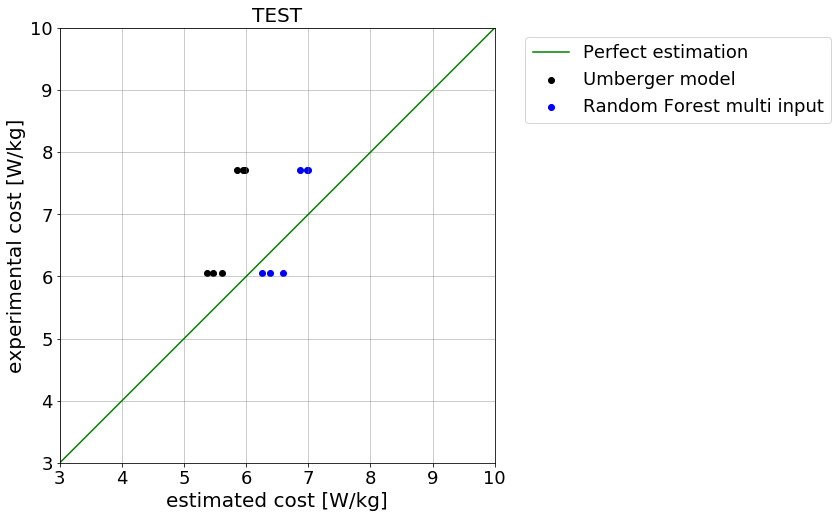

In [30]:
# try some predictions

# plot the random forest
fig1 = plt.figure(figsize=(8,8))
ax = fig1.add_subplot(111)

plt.scatter(x_train_multi_nn[:,0],y_train_multi_nn,
    c='black', label='Umberger model')
plt.scatter(y_pred_train_multi_nn, y_train_multi_nn,
    c='blue', label='NN multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TRAIN',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111)

plt.scatter(x_test_multi_nn[:,0],y_test_multi_nn,
    c='black', label='Umberger model')
plt.scatter(y_pred_test_multi_nn, y_test_multi_nn,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TEST',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()